## 1. Setup
Import modules


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
random_seed = 1
np.random.seed(random_seed)

## 2. Load data
Load data (it's already cleaned and preprocessed)


In [2]:
X_train = pd.read_csv('./ecomm_train_X.csv') 
y_train = pd.read_csv('./ecomm_train_y.csv') 
X_test = pd.read_csv('./ecomm_test_X.csv') 
y_test = pd.read_csv('./ecomm_test_y.csv') 

### 2.1 Addressing the Imbalance issue  by undersampling technique

In [3]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')

X_train, y_train = undersample.fit_resample(X_train, y_train)

print(Counter(y_train))

Counter({'Churn': 1})


<AxesSubplot:xlabel='Churn'>

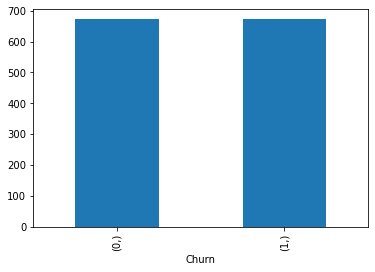

In [4]:
y_train.value_counts().plot(kind="bar")

## 3. Model the data
First, let's create a dataframe to load the model performance metrics into.


In [5]:
performance = pd.DataFrame({"model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1": []})

Conduct an initial random search across a wide range of possible parameters.

### 3.1 Decision Tree 
### Random Search Hyperparameter Tunning

## Metric Selection = Recall
Recall is a commonly used evaluation metric in churn prediction models, and it is often considered to be a more important metric than accuracy or precision for churn detection.

Recall, also known as sensitivity or true positive rate, measures the proportion of actual churners that are correctly identified as churners by the model. In other words, it measures the ability of the model to correctly identify all positive cases (i.e., customers who churned) out of the total number of positive cases. In the context of churn prediction, recall can be interpreted as the proportion of customers who are likely to churn that are correctly identified as such by the model. This is particularly important because identifying customers who are at risk of churning is critical for retaining them and minimizing customer churn.

In contrast, accuracy measures the proportion of all cases that are correctly identified by the model, regardless of whether they are positive or negative cases. Precision measures the proportion of predicted positive cases that are actually positive, and it is particularly useful in situations where the cost of false positives is high. However, in the context of churn prediction, the cost of false negatives (i.e., failing to identify customers who are likely to churn) is typically higher than the cost of false positives, making recall a more important metric for model evaluation.

Overall, while accuracy and precision are important metrics for evaluating the performance of churn prediction models, recall is often considered to be the most important metric for churn detection, as it directly measures the ability of the model to identify customers who are likely to churn.


In [6]:
score_measure = "recall"
kfolds = 15

criterion = ['gini', 'entropy']

max_depth = [int(x) for x in np.linspace(1, 4000, 10)]
min_samples_split = [int(x) for x in np.linspace(2, 5000, 10)]
min_samples_leaf = [int(x) for x in np.linspace(1, 10000, 10)]
max_leaf_nodes = [int(x) for x in np.linspace(2, len(y_test), 50)]
min_impurity_decrease = [x for x in np.arange(0.0, 0.01, 0.0001).round(5)]


param_grid = {
    'min_samples_split': min_samples_split,  
    'min_samples_leaf': min_samples_leaf,
    'min_impurity_decrease': min_impurity_decrease,
    'max_leaf_nodes': max_leaf_nodes, 
    'max_depth': max_depth, 
    'criterion': criterion,
}

dtree = DecisionTreeClassifier(random_state=random_seed)
best_random_search_model = RandomizedSearchCV(estimator = dtree, param_distributions=param_grid, cv=kfolds, n_iter=500,
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = best_random_search_model.fit(X_train, y_train)

Fitting 15 folds for each of 500 candidates, totalling 7500 fits


In [7]:
random_search_best_params = best_random_search_model.best_params_
print('Best parameters found: ', random_search_best_params)

Best parameters found:  {'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.0012, 'max_leaf_nodes': 1585, 'max_depth': 2222, 'criterion': 'gini'}


### 3.2 Decision Tree Grid Search Hyperparameter tunning (Close to Random Search Value)

In [8]:
score_measure = "recall"
kfolds = 5

plus_minus = 4
increment = 2

param_grid = { 'min_samples_split': [x for x in range(random_search_best_params['min_samples_split']-plus_minus, random_search_best_params['min_samples_split']+plus_minus,2) if x >= 2],       
              'min_samples_leaf': [x for x in range(random_search_best_params['min_samples_leaf']-plus_minus , random_search_best_params['min_samples_leaf']+plus_minus,2) if x > 0],
              'min_impurity_decrease': [x for x in np.arange(random_search_best_params['min_impurity_decrease']-0.001, random_search_best_params['min_impurity_decrease']+0.001,.0001).round(5) if x >= 0.000],
              'max_leaf_nodes':[x for x in range(random_search_best_params['max_leaf_nodes']-plus_minus , random_search_best_params['max_leaf_nodes']+plus_minus, 2) if x > 1],  
              'max_depth': [x for x in range(random_search_best_params['max_depth']-plus_minus , random_search_best_params['max_depth']+plus_minus, 2) if x > 1],
              'criterion': [random_search_best_params['criterion']]
             }

dtree = DecisionTreeClassifier(random_state=random_seed)
grid_search = GridSearchCV(estimator = dtree, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits
The best recall score is 0.8587285793255942
... with parameters: {'criterion': 'gini', 'max_depth': 2218, 'max_leaf_nodes': 1581, 'min_impurity_decrease': 0.0004, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [9]:
c_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Decision Tree Grid_Search", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

# 4.0 SVM Classification

### 4.1 SVM Random Search Hyperparameter tunning 

In [10]:
score_measure = "recall"
kfolds = 5

# defining parameter range
param_grid_svm = {
    'C': np.arange(1,25),
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf','poly'],
} 


best_random_search_model = RandomizedSearchCV(SVC(), param_distributions=param_grid_svm, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1, 
                           return_train_score=True)

_ = best_random_search_model.fit(X_train, np.ravel(y_train))


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [11]:
random_search_best_params = best_random_search_model.best_params_
print('Best parameters found: ', random_search_best_params)

Best parameters found:  {'kernel': 'rbf', 'gamma': 0.1, 'C': 9}


### 4.2 SVM Grid Search Hyperparameter tunning (Close to Randome Search Value)

In [12]:
score_measure = "recall"
kfolds = 5

# defining parameter range
param_grid_svm = {
    'C': np.arange(7,11,1),
    'gamma': np.arange(0.080,0.12,0.01),
    'kernel': ['rbf']
} 

grid_search_svm = GridSearchCV(SVC(), param_grid=param_grid_svm, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1, 
                           return_train_score=True)

_ = grid_search_svm.fit(X_train, np.ravel(y_train))

print(f"The best {score_measure} score is {grid_search_svm.best_score_}")
print(f"... with parameters: {grid_search_svm.best_params_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
The best recall score is 0.885428413488115
... with parameters: {'C': 7, 'gamma': 0.08, 'kernel': 'rbf'}


In [13]:
c_matrix_svm = confusion_matrix(y_test, grid_search_svm.predict(X_test))
TP = c_matrix_svm[1][1]
TN = c_matrix_svm[0][0]
FP = c_matrix_svm[0][1]
FN = c_matrix_svm[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"SVM Grid_Search", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

# 5.0 Logistic Regression

### 5.1 Logistic Regression Random Search Hyperparameter Tunning

In [14]:
score_measure = "recall"
kfolds = 5

# defining parameter range
param_grid_log = {
    'penalty' : ['none', 'l1', 'l2', 'elasticnet'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['newton-cg', 'lbfgs', 'liblinear']
} 

random_search_log = RandomizedSearchCV(LogisticRegression(), param_distributions=param_grid_log, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1, 
                           return_train_score=True)

_ = random_search_log.fit(X_train, np.ravel(y_train))

print(f"The best {score_measure} score is {random_search_log.best_score_}")
print(f"... with parameters: {random_search_log.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best recall score is 0.802089552238806
... with parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 4.281332398719396}


### 5.2 Logistic Regression Grid Search Hyperparameter Tunning (Very Close to Random search Values)

In [1]:
score_measure = "recall"
kfolds = 5

# defining parameter range
param_grid_log = {
    'penalty' : ['l1'],
    'C' : np.arange(2,7,1),
    'solver' : ['liblinear']
} 

grid_search_log = GridSearchCV(LogisticRegression(), param_grid=param_grid_log, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1, 
                           return_train_score=True)

_ = grid_search_log.fit(X_train, np.ravel(y_train))

print(f"The best {score_measure} score is {grid_search_log.best_score_}")
print(f"... with parameters: {grid_search_log.best_params_}")

NameError: name 'np' is not defined

In [16]:
c_matrix_log = confusion_matrix(y_test, grid_search_log.predict(X_test))
TP = c_matrix_log[1][1]
TN = c_matrix_log[0][0]
FP = c_matrix_log[0][1]
FN = c_matrix_log[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Logistic Grid_Search", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

## 6.0 Performance Evaluation and Comparison of Models

In [17]:
performance

,model,Accuracy,Precision,Recall,F1
0,Decision Tree Grid_Search,0.827709,0.485207,0.891304,0.628352
0,SVM Grid_Search,0.839550,0.505071,0.902174,0.647594
0,Logistic Grid_Search,0.769686,0.397086,0.789855,0.528485


## 7.0 Confusion Matrix for cost evaluation of best model (Decision Tree)

In [18]:
c_matrix  ## Confusion matric of Decision tree model

array([[1152,  261],
       [  30,  246]], dtype=int64)

The confusion matrix for the model reveals that there were 246 true positives (TP), 1152 true negatives (TN), 261 false positives (FP), and 30 false negatives (FN). The imbalanced target variable is a possible reason for such values.

Let's now examine how this churn detection model can benefit the e-commerce business in financial terms. Let's assume that the business generates an average revenue of USD 100 per month per customer, with an average customer lifetime value of USD 1,000. If the churn detection model can accurately identify an additional 10 customers per month who are at risk of churning, and the business can retain these customers, it would result in an extra monthly revenue of USD 1,000 (USD 100 per customer * 10 customers) and an additional customer lifetime value of USD 10,000 (USD 1,000 per customer * 10 customers) over the lifetime of these customers.

However, in our case from the confusion matrix there were 30 false negatives, meaning that the model predicted that these customers would not churn, whereas they actually churned. Based on the example values, the business would lose USD 3,000 per month (USD 100 per customer * 30 customers) and an additional customer lifetime value of USD 30,000 (USD 1,000 per customer * 30 customers) over the lifetime of these customers.

# Conclusion

### Churn detection is a crucial aspect for e-commerce businesses as it can have a significant impact on various factors such as revenue, customer lifetime value, customer satisfaction, and competition. It helps identify customers who are likely to leave, enabling businesses to take proactive measures to retain them and prevent revenue loss. Out of the three evaluated models, the SVM model has the highest recall value of 90.21%, which is the most important metric for churn detection. Besides recall, accuracy is also crucial as it reduces the number of false negatives and focuses on true positive customers. With a recall score of 0.902, the model can correctly identify 90.2% of customers who are likely to churn, indicating its ability to identify a significant proportion of at-risk customers.

